In [1]:
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet18, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchmetrics.aggregation import MeanMetric
from torchsummary import summary
from sklearn.metrics import classification_report

# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

# 1. Load Data

In [2]:
data = torchvision.datasets.CIFAR10(
    root='./data',
    download=True
)

Files already downloaded and verified


In [3]:
# https://discuss.pytorch.org/t/how-to-calculate-the-mean-and-the-std-of-cifar10-data/115222/2

# The mean and SD of the images is used for normalization
data_mean = data.data.mean(axis=(0, 1, 2)) / 255
data_std = data.data.std(axis=(0, 1, 2)) / 255

print(f"Data Mean: {data_mean}")
print(f"Data STD: {data_std}")

Data Mean: [0.49139968 0.48215841 0.44653091]
Data STD: [0.24703223 0.24348513 0.26158784]


In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomCrop(32, padding=4),  
    transforms.ToTensor(),  
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),  
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# 2. Explore data

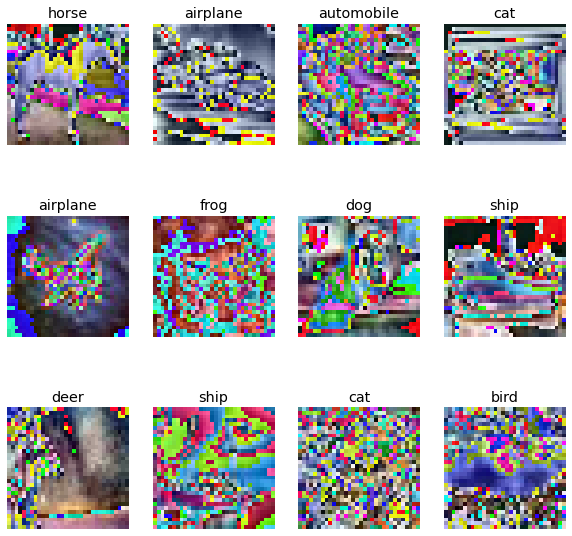

In [6]:
index = np.random.randint(0, len(test_dataset), size=12)
labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

fig, ax = plt.subplots(3, 4, figsize=(10, 10))
ax = ax.ravel()
for i in range(12):
    image, label = test_dataset[index[i]]
    ax[i].imshow(transforms.ToPILImage()(image))
    ax[i].axis("off")
    ax[i].set_title(labels[label])

# 3. Setup Model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
model = resnet18(weights="IMAGENET1K_V1").to(device)
# model = resnet50(weights="IMAGENET1K_V1").to(device)
# model = resnet18().to(device)
# model = resnet50().to(device)


model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(256, 10)
)
    
model = model.to(device)
    
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer)

# 5. Train Model

In [11]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []

loss_tracker = MeanMetric().to(device)
acc_tracker = MulticlassAccuracy(num_classes=10).to(device)

epochs = 50

for epoch in range(epochs):
    model.train()

    train_loader = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs} \t", ncols=100)
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device) 
        
        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        
        optimizer.step()
        
        loss_tracker.update(loss.item())
        acc_tracker.update(outputs, labels)
        
        train_loader.set_postfix(loss=loss_tracker.compute().item(), acc=acc_tracker.compute().item())
        
    train_loss.append(loss_tracker.compute().item())
    train_acc.append(acc_tracker.compute().item())
    
    loss_tracker.reset()
    acc_tracker.reset()
    
    with torch.no_grad():
        model.eval()
        
        val_loader = tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{epochs} \t", ncols=100)
        
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)

            loss = criterion(outputs, labels)
            
            loss_tracker.update(loss.item())
            acc_tracker.update(outputs, labels)
            
            val_loader.set_postfix(loss=loss_tracker.compute().item(), acc=acc_tracker.compute().item())
            
    test_loss.append(loss_tracker.compute().item())
    test_acc.append(acc_tracker.compute().item())
    
    scheduler.step(loss_tracker.compute().item())

    loss_tracker.reset()
    acc_tracker.reset()

Validation Epoch 50/50 	: 100%|██████████████| 79/79 [00:01<00:00, 48.50it/s, acc=0.762, loss=0.692]


# 6. Test Model

In [12]:
pred_all = []
truth_all = []

with torch.no_grad():
    model.eval()

    test_loader = tqdm(test_dataloader, desc=f"Validation Epoch {epoch+1}/{epochs} \t", ncols=100)

    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        
        pred_all.append(torch.argmax(outputs, dim=1).cpu())
        truth_all.append(labels.cpu())

pred_all = torch.cat(pred_all, dim=0)
truth_all = torch.cat(truth_all, dim=0)

print(classification_report(truth_all, pred_all))

Validation Epoch 50/50 	: 100%|█████████████████████████████████████| 79/79 [00:01<00:00, 59.53it/s]

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.86      0.87      0.86      1000
           2       0.73      0.67      0.70      1000
           3       0.62      0.60      0.61      1000
           4       0.75      0.74      0.74      1000
           5       0.70      0.68      0.69      1000
           6       0.77      0.88      0.82      1000
           7       0.83      0.80      0.81      1000
           8       0.83      0.89      0.86      1000
           9       0.86      0.82      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



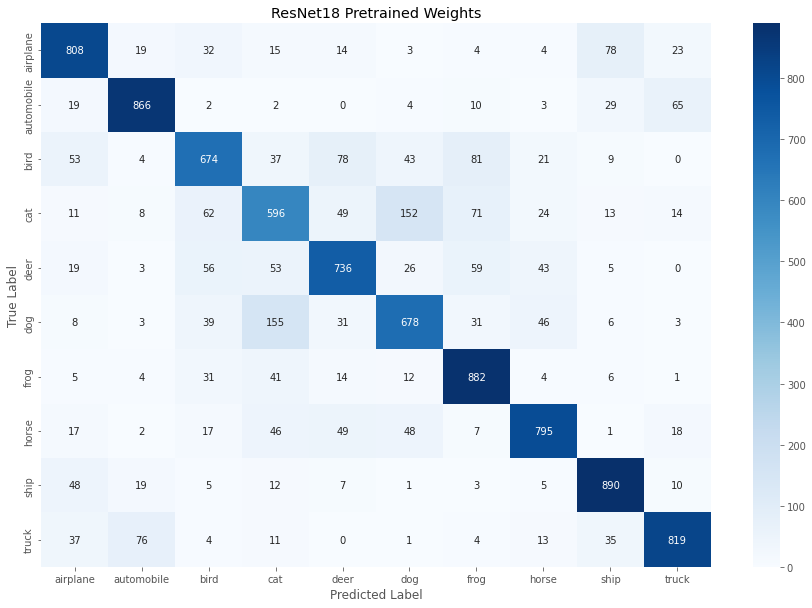

In [13]:
cm = confusion_matrix(truth_all, pred_all)

labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(cm, annot=True, ax=ax,fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ResNet18 Pretrained Weights")
plt.savefig("resnet18-pretrained-cfm.pdf", format="pdf", bbox_inches="tight")

plt.show()



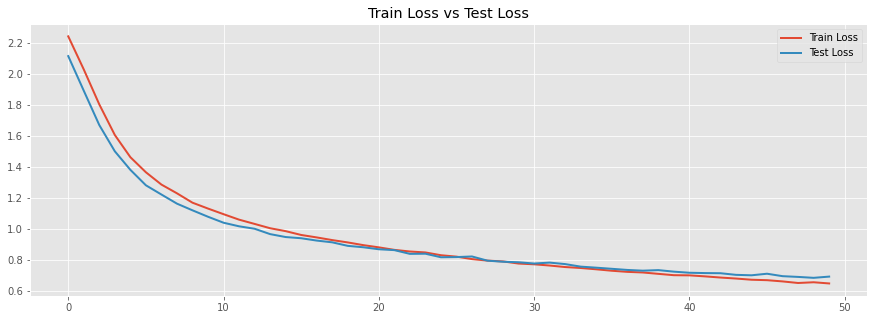

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(np.arange(len(train_loss)), train_loss, label="Train Loss", linewidth=2)
plt.plot(np.arange(len(test_loss)), test_loss, label="Test Loss", linewidth=2)
plt.title("Train Loss vs Test Loss")
plt.legend()
plt.show()

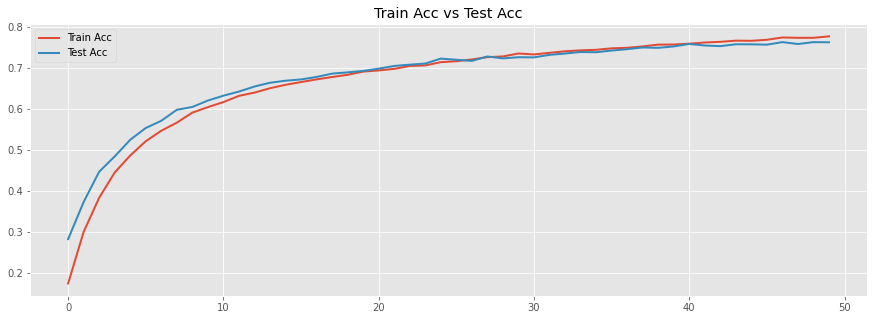

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(np.arange(len(train_acc)), train_acc, label="Train Acc", linewidth=2)
plt.plot(np.arange(len(test_acc)), test_acc, label="Test Acc", linewidth=2)
plt.title("Train Acc vs Test Acc")
plt.legend()
plt.show()

# Save Plotting Data

In [229]:
np.savez("resnet18-pretrained.npz", train_acc=np.array(train_acc), test_acc=np.array(test_acc), train_loss=np.array(train_loss), test_loss=np.array(test_loss))